# *** hyperparameter analysis, NN, MLPR  for 'TT_full_binned+TE_full_binned+EE_full_binned' multipoles coming from planck 2018 result ***

In [ ]:
## Rcll: n_s=0.9649 ± 0.0044 and Log(10^10 A_s)=3.045 ± 0.016 
## Ref.  arXiv:1807.06209 Table 2 see column-[4]

In [ ]:
## install
#!pip install camb
#!pip install getdist

# import libraries

In [1]:
## import libraries
from platform import python_version
#print(python_version())

import pandas as pd
import numpy  as np
from numpy     import multiply, product
from itertools import product

import seaborn as sns
import os
import pickle
import time

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from   matplotlib import pylab
from   matplotlib import cm
from   matplotlib.gridspec import GridSpec
#sns.set_style("whitegrid")
np.random.seed(697)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import sklearn
from sklearn                 import model_selection
from sklearn.model_selection import train_test_split
from sklearn.neural_network  import MLPRegressor
from sklearn.preprocessing   import StandardScaler
from sklearn.preprocessing   import RobustScaler
from sklearn.pipeline        import make_pipeline
from sklearn.tree            import DecisionTreeRegressor
from sklearn.inspection      import plot_partial_dependence     
from sklearn                 import preprocessing
from sklearn                 import metrics
from sklearn.metrics         import r2_score, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score, mean_squared_error 
from sklearn.datasets        import make_classification
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.preprocessing   import *

import getdist, IPython
#print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))
from getdist import plots, MCSamples

import warnings
warnings.filterwarnings("ignore")

In [ ]:
## drive
#from google.colab import drive
#from itertools import product
#drive.mount('/content/drive/')

# directories & paths for dataset files

In [2]:
## directories
directory_c  = 'camb18_dataset/'
directory_p  = 'planck18_CMB_ps_dataset/'

In [3]:
## path for TT_fb_TEEE_fb comp.from camb
camb_ds_fname = 'TT_full_binned+TE_full_binned+EE_full_binned.csv'
camb_ds       = pd.read_csv(directory_c + camb_ds_fname)

ps = camb_ds.drop(['ns','As'], axis=1).values
cp = camb_ds.iloc[:,:2].values

In [4]:
## path for TT_fb_TEEE_fb comp. from planck18
planck_ds_fname = 'TT_full_binned+TE_full_binned+EE_full_binned.csv'
planck_ds       = pd.read_csv(directory_p + planck_ds_fname)

planck = planck_ds['Dl'].values
planck = planck.reshape([1, len(planck)])

# MSE fnc definition

In [5]:
## MSE fnc definition
def get_loss(NN, X, y): 
    y_hat  = NN.predict(X)
    loss   = np.mean((y-y_hat)**2)/2
    ## Add L2 (Ridge) regularization term to loss
    L2term = np.sum(np.array([np.dot(s.ravel(), s.ravel()) for s in NN.coefs_]))
    loss  += ((0.5 * NN.alpha) * L2term) / X.shape[0]
    return loss  

# Plot definition

In [6]:
## Plot definition
def hpa_loss_plot(hyper_params,final_results,cp_test,cp_pred_mean,cp_pred_std,residuals,
                  test_loss,val_loss,tr_loss,score,nof_NN,dt,counter):  
    fig, ax = plt.subplots(1,5,figsize=(21,4),gridspec_kw={'hspace':0.0,'wspace':0.35},dpi=95)
    nbins   = 50
        
    ax[0].errorbar(cp_test[:,0],cp_pred_mean[:,0],cp_pred_std[:,0],marker='.',ls='',lw=1.0,mec='violet',mew=0.5,mfc='w',color='violet',
                   label='$%.5f\pm%.5f$'%(final_results[:,0].mean(),final_results[:,0].std()))  
    ax[0].plot([min(cp_pred_mean[:,0]),max(cp_pred_mean[:,0])],[min(cp_pred_mean[:,0]),max(cp_pred_mean[:,0])],color='red',lw=0.90,zorder=10)
    ax[0].set_xlabel(r'The true value of $n_s$')
    ax[0].set_ylabel(r'The predicted value of $n_s$')
    ax[0].legend(loc='upper left')
    in0 = plt.axes([0.18,0.3,0.055,0.15])
    in0.hist(residuals[:,0],bins=nbins,color='violet',histtype='stepfilled',density=True,lw=0.75)
    in0.set_xlim([-0.06,0.06])
    in0.set_yticks([])
    in0.set_xticks([-0.05,0,0.05])
    in0.set_xticklabels([-0.05,0,0.05],rotation=0)
    in0.spines['right'].set_visible(False)
    in0.spines['top'].set_visible(False)
    in0.spines['left'].set_visible(False)
           
    ax[1].errorbar(cp_test[:,1],cp_pred_mean[:,1],cp_pred_std[:,1],marker='.',ls='',lw=1.0,mec='lightskyblue',mew=0.5,mfc='w',color='lightskyblue',
                   label='$%.5f\pm%.5f$'%(final_results[:,1].mean(),final_results[:,1].std()))
    ax[1].plot([min(cp_pred_mean[:,1]),max(cp_pred_mean[:,1])],[min(cp_pred_mean[:,1]),max(cp_pred_mean[:,1])],color='red',lw=0.90,zorder=10)
    ax[1].set_xlabel(r'The true value of $Log (10^{10} \mathcal{A}_s)$')
    ax[1].set_ylabel(r'The predicted value of $Log (10^{10} \mathcal{A}_s)$') 
    ax[1].legend(loc='upper left')
    in1 = plt.axes([0.345,0.3,0.055,0.15])
    in1.hist(residuals[:,1],bins=nbins,color='lightskyblue',histtype='stepfilled',density=True,lw=0.75)
    in1.set_xlim([-0.06,0.06])
    in1.set_yticks([])
    in1.set_xticks([-0.05,0,0.05])
    in1.set_xticklabels([-0.05,0,0.05],rotation=0)
    in1.spines['right'].set_visible(False)
    in1.spines['top'].set_visible(False)
    in1.spines['left'].set_visible(False)  
          
    ax[2].hist(final_results[:,0],bins=nbins,histtype='stepfilled',density=True,color='violet')
    ax[2].set_xlabel(r'$n_s = %.5f\pm%.5f$'%(final_results[:,0].mean(),final_results[:,0].std()))
    ax[2].set_ylabel('Density')
    
    ax[3].hist(final_results[:,1],bins=nbins,histtype='stepfilled',density=True,color='lightskyblue')
    ax[3].set_xlabel(r'$Log (10^{10} \mathcal{A}_s) = %.5f\pm%.5f$'%(final_results[:,1].mean(),final_results[:,1].std()))
    ax[3].set_ylabel('Density')
    
    ax[4].semilogy(test_loss, color='cyan') 
    ax[4].semilogy(val_loss,  color='fuchsia') 
    ax[4].semilogy(tr_loss,   color='mediumslateblue')
    ax[4].set_xlabel('Num. of Epoch: {}'.format(nof_NN))
    ax[4].set_ylabel('Loss (Num. of Epoch)')
    ax[4].legend(['Test Loss', 'Validation Loss', 'Train Loss'],
                 loc='center',bbox_to_anchor=(0.5,0.5))   
    
    return fig  
 
    plt.tight_layout()                                                                                                    
    plt.show()

# NNs, hyper_params, MLPR

 loading fitted dataset to NN_file completed:  [0/1000]  in  0.013797450065612792  minutes 
 loading fitted dataset to NN_file completed:  [250/1000]  in  2.208589001496633  minutes 
 loading fitted dataset to NN_file completed:  [500/1000]  in  4.305109186967214  minutes 
 loading fitted dataset to NN_file completed:  [750/1000]  in  6.354918769995371  minutes 


,R2,dR2,ns,dns,As,dAs,Time (mins),Scaler,HLS,AF,Solver,alpha,Figure
1,0.997764,0.000682,1.292654,0.135465,2.952646,0.132005,8.448694,RobustScaler,"(10, 10, 10)",logistic,lbfgs,0.01,Figure(1995x380)


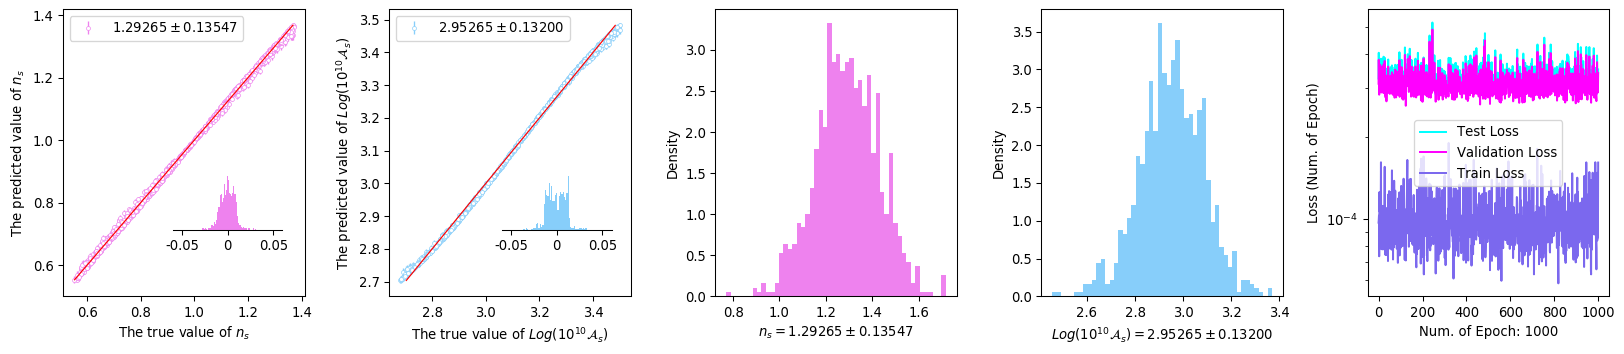

In [7]:
## create NNs and get the best combinations of hyper_params 
## by using an MLPRegression
scalers     = [RobustScaler()]
hlss        = [(10,10,10)]
activations = ['logistic']
solvers     = ['lbfgs']
alphas      = [0.01]

columns = ['R2','dR2','ns','dns','As','dAs','Time (mins)','Scaler','HLS','AF','Solver','alpha','Figure']
df      = pd.DataFrame(columns=columns)
counter = 1
directory_NN = 'NN18/NN18_TT_full_binned+TE_full_binned+EE_full_binned/'
    
for hyper_params in product(scalers,hlss,activations,solvers,alphas):    
    scalers     = hyper_params[0]
    hlss        = hyper_params[1]
    activations = hyper_params[2]
    solvers     = hyper_params[3]
    alphas      = hyper_params[4]
  
    scaler   = scalers.fit(ps) 
    ps_s     = scaler.transform(ps)
    planck_s = scaler.transform(planck)
    ps_train,ps_test,cp_train,cp_test=train_test_split(ps_s,cp,test_size=0.1)
    np.savetxt('results18/planck_s/TT_full_binned+TE_full_binned+EE_full_binned.txt',planck_s)
        
    final_results = []    
    ps_test_pred  = []
    
    score         = []
    test_score    = []
    val_score     = []
    tr_score      = []
    
    test_loss     = []
    val_loss      = []
    tr_loss       = []
    
    t0     = time.time()
    nof_NN = 1000
    for i in range(nof_NN):   
        ps_tr,ps_val,cp_tr,cp_val=train_test_split(ps_train,cp_train,test_size=0.12)
        ## set the method
        mlpr    = MLPRegressor(hidden_layer_sizes=hlss,activation=activations,solver=solvers,alpha=alphas,
                               verbose=False,early_stopping=True,learning_rate='adaptive',batch_size='auto',
                               max_iter=200,momentum=0.9) 
        ## for tuning the hps by fitting val_dataset part
        NN      = mlpr.fit(ps_val,cp_val)
        NN_name = 'NN18_%d'%i
        pickle.dump(NN, open(directory_NN+NN_name+'.pkl', 'wb'))   
        if i%250==0:
            print('\033[1;35m loading fitted dataset to NN_file completed: \033[1;m [{}/{}]'.format(i,nof_NN), 
                  '\033[1;35m in \033[1;m', (time.time()-t0)/60, '\033[1;35m minutes \033[1;m')    
        NN = pickle.load(open(directory_NN+NN_name+'.pkl', 'rb'))
        
        ps_test_pred.append(NN.predict(ps_test))
        pred = NN.predict(planck_s)
        final_results.append(pred[0])
        
        test_score.append(NN.score(ps_test,cp_test))
        val_score.append(NN.score(ps_val,cp_val))
        tr_score.append(NN.score(ps_tr,cp_tr))
        
        test_loss.append(get_loss(NN,ps_test,cp_test))
        val_loss.append(get_loss(NN,ps_val,cp_val))
        tr_loss.append(get_loss(NN,ps_tr,cp_tr))
    
    final_results = np.array(final_results)       
    ps_test_pred  = np.array(ps_test_pred)
    cp_pred_mean  = ps_test_pred.mean(axis=0)
    cp_pred_std   = ps_test_pred.std(axis=0)
    residuals     = (cp_test - cp_pred_mean)  
    dt            = (time.time() - t0)/60
            
    p = hpa_loss_plot(hyper_params,final_results,cp_test,cp_pred_mean,cp_pred_std,residuals,
                      test_loss,val_loss,tr_loss,score,nof_NN,dt,counter)   
    
    data_for_df  = [np.mean(test_score),np.std(test_score),
                    final_results[:,0].mean(),final_results[:,0].std(),
                    final_results[:,1].mean(),final_results[:,1].std(),dt]
    data_for_df += [str(hyper_params[0]).split('(')[0],hyper_params[1],hyper_params[2],hyper_params[3],hyper_params[4]]
    data_for_df += [p]
    df.loc[counter] = data_for_df
    counter        += 1
    
#plt.savefig('results18/hpa18_TT_fb+TEEE_fb.pdf')

df    

# score acc & pipeline for MLPR model

In [8]:
## score acc for the datasets
print('\033[1;33m \nscore acc calculation for the datasets: \033[1;m')

print('\033[1;36m \nFor test dataset, R^2 +- dR^2 = \033[1;m %.6f +- %.6f'%(np.mean(test_score),np.std(test_score)),
      '\033[1;35m \nFor validation dataset, R^2 +- dR^2 = \033[1;m %.6f +- %.6f'%(np.mean(val_score),np.std(val_score)),
      '\033[1;34m \nFor train dataset, R^2 +- dR^2 = \033[1;m %.6f +- %.6f'%(np.mean(tr_score),np.std(tr_score)))

print('\033[1;37m=s=\033[1;m'*25)

## summation of model
print('\033[1;33m \nsummation of model: \033[1;m')

mlpr_sum = make_pipeline(RobustScaler(),mlpr)
mlpr_sum

 
score acc calculation for the datasets: 
 
For test dataset, R^2 +- dR^2 =  0.997764 +- 0.000682  
For validation dataset, R^2 +- dR^2 =  0.997734 +- 0.000691  
For train dataset, R^2 +- dR^2 =  0.997666 +- 0.000714
=s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s=
 
summation of model: 


Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('mlpregressor',
                 MLPRegressor(activation='logistic', alpha=0.01,
                              batch_size='auto', beta_1=0.9, beta_2=0.999,
                              early_stopping=True, epsilon=1e-08,
                              hidden_layer_sizes=(10, 10, 10),
                              learning_rate='adaptive',
                              learning_rate_init=0.001, max_fun=15000,
                              max_iter=200, momentum=0.9, n_iter_no_change=10,
                              nesterovs_momentum=True, power_t=0.5,
                              random_state=None, shuffle=True, solver='lbfgs',
                              tol=0.0001, validation_fraction=0.1,
                              verbose=False, warm_start=False))],
         verbos

# statistical plot for prediction of parameters, n_s and A_s 

In [9]:
names   = ['n_s', 'Log(10^{10}\mathcal{A}_s)']
labels  = ['n_s', 'Log(10^{10}\mathcal{A}_s)']
samples = [MCSamples(samples=final_results,names=names,labels=labels)]

Removed no burn in


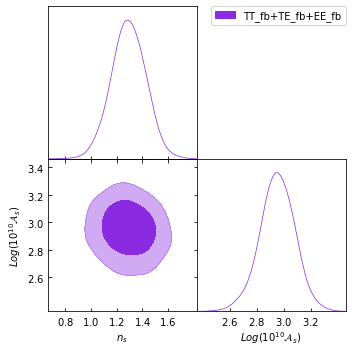

In [10]:
g = plots.get_subplot_plotter(width_inch=5.0)
g.settings.num_plot_contours   = 2
g.settings.figure_legend_frame = True
g.settings.alpha_filled_add    = 0.4
g.settings.legend_fontsize     = 12
g.settings.axes_fontsize       = 12
g.settings.axes_labelsize      = 12

g.triangle_plot(samples,filled=True,alpha =1.0,contour_colors=['blueviolet','blueviolet'],
                legend_labels=['TT_fb+TE_fb+EE_fb'],legend_loc='upper right',bbox_inches='tight')

#plt.savefig('results18/pred18_TT_fb+TEEE_fb.pdf')

# about datasets

In [11]:
## about datasets
print('\033[1;35m length of ps_s: \033[1;m', len(ps_s))
print('\033[1;35m dtype of ps_s: \033[1;m',  ps_s.dtype)
print('\033[1;35m shape of ps_s: \033[1;m',  ps_s.shape)
print()
print('\033[1;37m=s=\033[1;m'*25)
print()
print('\033[1;35m length of cp: \033[1;m', len(cp))
print('\033[1;35m dtype of cp: \033[1;m',  cp.dtype)
print('\033[1;35m shape of cp: \033[1;m',  cp.shape)
print()
print('\033[1;37m=s=\033[1;m'*25)
print()
print('\033[1;36m length of ps_train: \033[1;m', len(ps_train))
print('\033[1;36m dtype of ps_train: \033[1;m',  ps_train.dtype)
print('\033[1;36m shape of ps_train: \033[1;m',  ps_train.shape)
print()
print('\033[1;37m=s=\033[1;m'*25)
print()
print('\033[1;36m length of ps_test: \033[1;m', len(ps_test))
print('\033[1;36m dtype of ps_test: \033[1;m',  ps_test.dtype)
print('\033[1;36m shape of ps_test: \033[1;m',  ps_test.shape)
print()
print('\033[1;37m=s=\033[1;m'*25)
print()
print('\033[1;36m length of cp_train: \033[1;m', len(cp_train))
print('\033[1;36m dtype of cp_train: \033[1;m',  cp_train.dtype)
print('\033[1;36m shape of cp_train: \033[1;m',  cp_train.shape)
print()
print('\033[1;37m=s=\033[1;m'*25)
print()
print('\033[1;36m length of cp_test: \033[1;m', len(cp_test))
print('\033[1;36m dtype of cp_test: \033[1;m',  cp_test.dtype)
print('\033[1;36m shape of cp_test: \033[1;m',  cp_test.shape)
print()
print('\033[1;37m=s=\033[1;m'*25)
print()
print('\033[1;36m length of ps_tr: \033[1;m', len(ps_tr))
print('\033[1;36m dtype of ps_tr: \033[1;m',  ps_tr.dtype)
print('\033[1;36m shape of ps_tr: \033[1;m',  ps_tr.shape)
print()
print('\033[1;37m=s=\033[1;m'*25)
print()
print('\033[1;36m length of ps_val: \033[1;m', len(ps_val))
print('\033[1;36m dtype of ps_val: \033[1;m',  ps_val.dtype)
print('\033[1;36m shape of ps_val: \033[1;m',  ps_val.shape)
print()
print('\033[1;37m=s=\033[1;m'*25)
print()
print('\033[1;36m length of cp_tr: \033[1;m', len(cp_tr))
print('\033[1;36m dtype of cp_tr: \033[1;m',  cp_tr.dtype)
print('\033[1;36m shape of cp_tr: \033[1;m',  cp_tr.shape)
print()
print('\033[1;37m=s=\033[1;m'*25)
print()
print('\033[1;36m length of cp_val: \033[1;m', len(cp_val))
print('\033[1;36m dtype of cp_val: \033[1;m',  cp_val.dtype)
print('\033[1;36m shape of cp_val: \033[1;m',  cp_val.shape)

 length of ps_s:  10001
 dtype of ps_s:  float64
 shape of ps_s:  (10001, 299)

=s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s=

 length of cp:  10001
 dtype of cp:  float64
 shape of cp:  (10001, 2)

=s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s=

 length of ps_train:  9000
 dtype of ps_train:  float64
 shape of ps_train:  (9000, 299)

=s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s=

 length of ps_test:  1001
 dtype of ps_test:  float64
 shape of ps_test:  (1001, 299)

=s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s=

 length of cp_train:  9000
 dtype of cp_train:  float64
 shape of cp_train:  (9000, 2)

=s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s=

 length of cp_test:  1001
 dtype of cp_test:  float64
 shape of cp_test:  (1001, 2)

=s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s=

 length of ps_tr:  7920
 dtype of ps

In [12]:
## weights btwn layers
print('\033[1;35m (w_0)weights between input layer and first hidden layer: \033[1;m')
print(NN.coefs_[0])
print()
print('\033[1;37m=s=\033[1;m'*25)
print()
print('\033[1;35m (w_1)weights between first hidden layer and second hidden layer: \033[1;m')
print(NN.coefs_[1])
print()
print('\033[1;37m=s=\033[1;m'*25)
print()
print('\033[1;35m (w_2)weights between second hidden layer and third hidden layer: \033[1;m')
print(NN.coefs_[2])
print()
print('\033[1;37m=s=\033[1;m'*25)
print()
print('\033[1;35m (w_3)weights between third hidden layer and output layer: \033[1;m')
print(NN.coefs_[3])

 (w_0)weights between input layer and first hidden layer: 
[[ 0.0537255   0.06627624 -0.05383469 ... -0.00661617  0.01028197
   0.01565739]
 [ 0.05363448 -0.00699226  0.01668405 ... -0.07702305  0.05350151
  -0.02655065]
 [ 0.03911438  0.01670033 -0.02950385 ...  0.0205907  -0.00574203
  -0.0597186 ]
 ...
 [ 0.06413378  0.02468913 -0.04221891 ...  0.07028052 -0.0616115
   0.0487421 ]
 [-0.03480546  0.02497836  0.0250223  ... -0.01495226  0.02351735
  -0.0252768 ]
 [ 0.00938909 -0.07123122 -0.00741696 ...  0.03588814 -0.0418298
   0.02391743]]

=s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s=

 (w_1)weights between first hidden layer and second hidden layer: 
[[-0.58170508  0.46028117  0.06866727 -0.37922257 -0.25329297  0.43615807
  -0.57967811  0.25654543  0.1204524  -0.25723198]
 [-0.5149756  -0.24165009 -0.41336354 -0.60359803 -0.19702207  0.31688646
   0.14335214 -0.62625596  0.42958301  0.23586847]
 [ 0.49147562  0.33701467  0.00969361  0.61167463  0.056

In [13]:
## neurons H_ij
for i in range(len(NN.coefs_)):
    number_neurons_in_layer = NN.coefs_[i].shape[1]
    for j in range(number_neurons_in_layer):
        weights = NN.coefs_[i][:,j]
        print(i, j, weights, end=", ")
        print()
    print()

0 0 [ 0.0537255   0.05363448  0.03911438  0.0427625   0.0653544   0.05822752
  0.00791066 -0.04648378  0.06426679  0.01581377  0.05641238  0.05452314
 -0.05616849  0.05378054  0.06476372  0.036101   -0.08046953  0.061588
  0.0288011   0.01701408  0.07022732 -0.01760092  0.06337328  0.02137473
 -0.02807451  0.04499735 -0.04350874  0.07245488  0.05076873  0.01887512
 -0.08204178 -0.06793399 -0.0825334  -0.04585028 -0.04155809 -0.08197157
  0.04757794  0.0181126   0.02681313  0.03850611  0.01316227 -0.07282937
  0.01359338  0.05523664  0.00623961  0.03649389 -0.07808234 -0.04459715
 -0.04774847  0.0654501  -0.00288574 -0.07682308  0.06343728  0.01372759
  0.00517026 -0.02324937  0.03138875 -0.01140392 -0.06155153  0.0540124
  0.02539557  0.06262023  0.03427732 -0.01231553  0.0132084   0.0151043
 -0.0058976   0.02674035 -0.03002604 -0.0041245   0.00626616 -0.02858144
 -0.02493916 -0.06642426  0.01300674  0.08011778 -0.04498767  0.06669848
  0.00655849  0.07252566 -0.05876636 -0.01554348  0

In [14]:
## bias values 
print('\033[1;36m (B_0j)Bias values for first hidden layer: \033[1;m')
print(NN.intercepts_[0])
print()
print('\033[1;37m=s=\033[1;m'*25)
print()
print('\033[1;36m (B_1j)Bias values for second hidden layer: \033[1;m')
print(NN.intercepts_[1])
print()
print('\033[1;37m=s=\033[1;m'*25)
print()
print('\033[1;36m (B_2j)Bias values for third hidden layer: \033[1;m')
print(NN.intercepts_[2])
print()
print('\033[1;37m=s=\033[1;m'*25)
print()
print('\033[1;36m (B_3j)Bias values for output layer: \033[1;m')
print(NN.intercepts_[3])

 (B_0j)Bias values for first hidden layer: 
[-0.18695967 -0.08290148 -0.02524826  0.21738239 -0.14597032 -0.32680728
 -0.06950151  0.16577244 -0.08999428 -0.04588974]

=s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s=

 (B_1j)Bias values for second hidden layer: 
[ 0.08856921 -0.27328184 -0.24145189  0.25021753  0.08328042 -0.05542376
  0.14710236 -0.2241288  -0.24945865  0.37503313]

=s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s=

 (B_2j)Bias values for third hidden layer: 
[ 0.08480694  0.01202221 -0.00227065 -0.05134401 -0.05547781  0.24191785
 -0.2154379   0.15652127 -0.15123538 -0.00892676]

=s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s==s=

 (B_3j)Bias values for output layer: 
[0.50596155 0.60111026]
